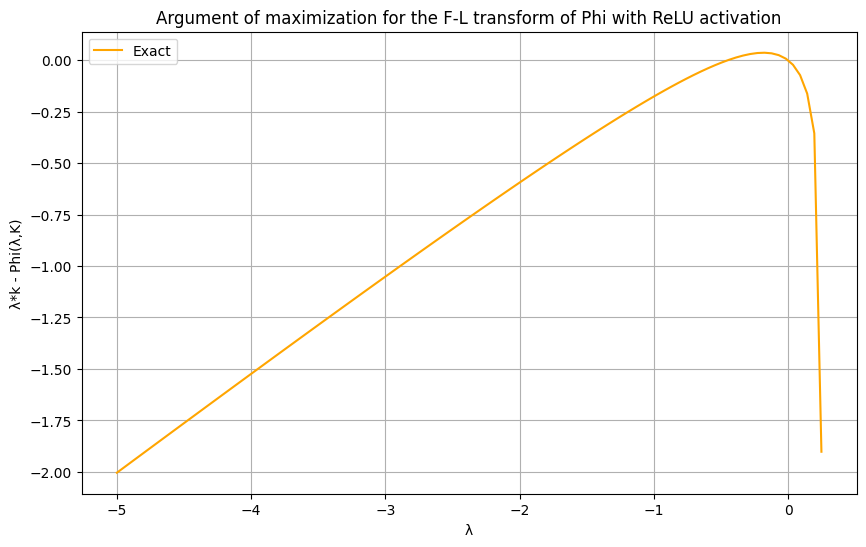

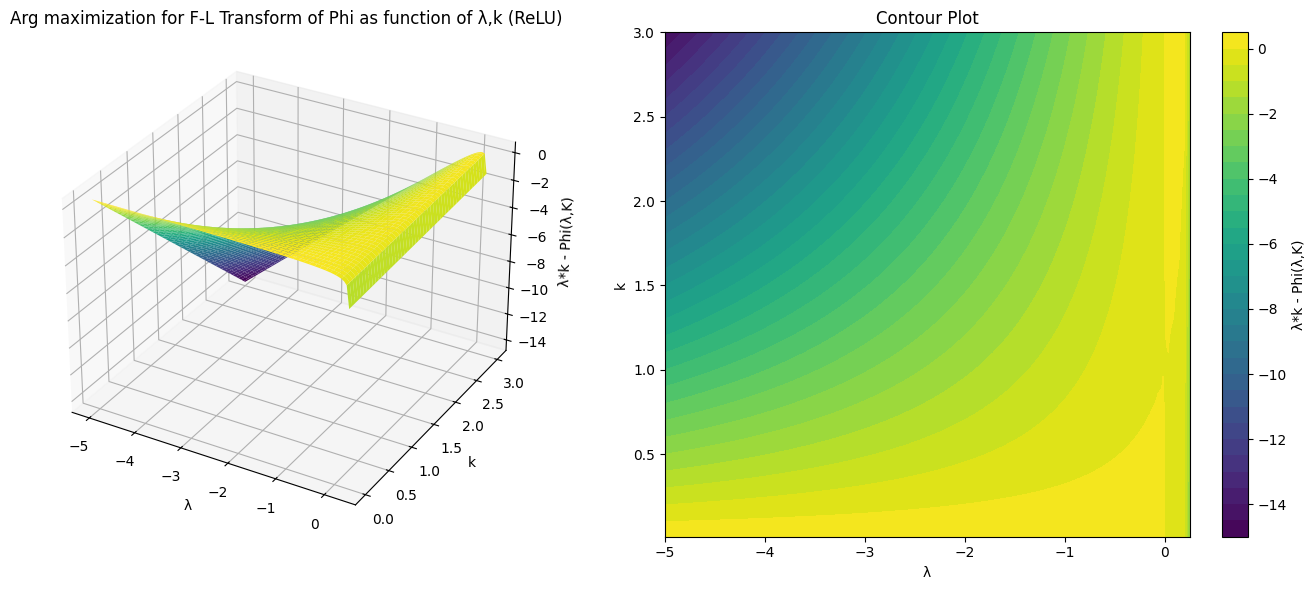

In [1]:
# In the case of ReLU we have an explicit formula only for the LMGT

import numpy as np

# Define the LMGT (Phi)
def Phi(lam, k):
    return np.log((1 + (1 - 2 * lam * k)**(- 1 / 2)) / 2)

# Define the gradient of Phi with respect to lambda
def gradient_Phi_lam(lam, k):
    return k / ((1 - 2 * lam * k) * (1 + np.sqrt(1 - 2 * lam * k)))

# Define the gradient of Phi with respect to k
def gradient_Phi_k(lam, k):
    return lam / ((1 - 2 * lam * k) * (1 + np.sqrt(1 - 2 * lam * k)))

# Define the hessian of Phi with respect to lambda
def hessian_Phi_lam(lam, k):
    return (-6 * lam * k**3 + 2 * k**2 * np.sqrt(1 - 2 * lam * k) + 3 * k**2) / ((1 - 2 * lam * k)**(5 / 2) * (1 + np.sqrt(1 - 2 * lam * k))**2)

# Define the hessian of Phi with respect to k
def hessian_Phi_k(lam, k):
    return (-6 * lam**3 * k + 2 * lam**2 * np.sqrt(1 - 2 * lam * k) + 3 * lam**2) / ((1 - 2 * lam * k)**(5 / 2) * (1 + np.sqrt(1 - 2 * lam * k))**2)

# Define the mixed hessian of Phi
def mixed_hessian_Phi(lam, k):
    return (1 + np.sqrt(1 - 2 * lam * k) - (lam * k) - 2 * (lam * k)**2) / ((1 - 2 * lam * k)**(5 / 2) * (1 + np.sqrt(1 - 2 * lam * k))**2)

# Test the functions
import matplotlib.pyplot as plt
k_0 = 2
k_1 = 0.5
# Range of lambda values
lambda_values = np.linspace(-5, 1 / (2.01 * k_0), 100)
# Compute the analytic argument of maximization for the F-L transform of Phi
results_phi = [k_1 * lam - Phi(lam, k_0)  for lam in lambda_values]
# Plotting
plt.figure(figsize = (10, 6))
plt.plot(lambda_values, results_phi, label = 'Exact', linestyle = '-', color = 'orange')
plt.title(f'Argument of maximization for the F-L transform of Phi with ReLU activation')
plt.xlabel('λ')
plt.ylabel('λ*k - Phi(λ,K)')
plt.grid()
plt.legend()
plt.show()

# Grid points for 3D plot + contour plot
k_1_values = np.linspace(0.01, 3, 100)
LAM, K1 = np.meshgrid(lambda_values, k_1_values)
k_values = np.stack([LAM.ravel(), K1.ravel()], axis=1)
# Analytic solution
results = [k[1] * k[0] - Phi(k[0], k_0) for k in k_values]
results = np.array(results).reshape(LAM.shape)
# Plotting
fig = plt.figure(figsize = (14, 6))
# Plot 3D
ax1 = fig.add_subplot(1, 2, 1, projection = '3d')
ax1.plot_surface(LAM, K1, results, cmap = 'viridis', edgecolor = 'none')
ax1.set_title(f"Arg maximization for F-L Transform of Phi as function of λ,k (ReLU)")
ax1.set_xlabel('λ')
ax1.set_ylabel('k')
ax1.set_zlabel('λ*k - Phi(λ,K)')
# Contour plot
ax2 = fig.add_subplot(1, 2, 2)
contour = ax2.contourf(LAM, K1, results, levels = 30, cmap = 'viridis')
fig.colorbar(contour, ax = ax2, label = 'λ*k - Phi(λ,K)')
ax2.set_title(f"Contour Plot")
ax2.set_xlabel('λ')
ax2.set_ylabel('k')
plt.tight_layout()
plt.show()

In [2]:
# Numerical methods to compute the Fenchel-Legendre transform of Phi
# All the functions return the dobuble (optimal value, the optimal point)

# Scipy optimization
from scipy.optimize import minimize # if we want to maximize we can use the relation max f = -min (-f)
def Phi_conjugate_Scipy(k_1, k_0, starting_point = -0.5):
    def objective(lam):
            return -lam * k_1 + Phi(lam, k_0), -k_1 + gradient_Phi_lam(lam, k_0)
    result = minimize(objective, starting_point, jac = True, method='L-BFGS-B', bounds = ((-np.inf, 1 / (2.0001 * k_0)),), options = {'disp': False})
    if not result.success:
        raise ValueError("Optimization failed: " + result.message)
    return -result.fun, result.x[0]

# Gradient Ascent
def Phi_conjugate_GA(k_1, k_0, learning_rate = 0.1, starting_point = -0.5, num_iterations = 30):
    if starting_point >= 1 / (2 * k_0): # check the starting point is in the domain
        # max possible starting point
        lam = 1 / (2.1 * k_0)
    else:
        lam = starting_point
    for _ in range(num_iterations):
        grad_Phi_lam = gradient_Phi_lam(lam, k_0)
        grad = k_1 - grad_Phi_lam
        lam_updated = lam + learning_rate * grad
        if lam_updated > 1 / (2 * k_0):
            # max possible step
            lam = 1 / (2.1 * k_0)
        else:
            lam = lam_updated
    Phi_conj = lam * k_1 - Phi(lam, k_0)
    return Phi_conj, lam

# Newton's method
def Phi_conjugate_Newton(k_1, k_0, starting_point = -0.5, num_iterations = 10):
    if starting_point >= 1 / (2 * k_0): # check the starting point is in the domain
        # max possible starting point
        lam = 1 / (2.01 * k_0)
    else:
        lam = starting_point
    for _ in range(num_iterations):
        grad_Phi_lam = gradient_Phi_lam(lam, k_0)
        hess_Phi_lam = hessian_Phi_lam(lam, k_0)
        grad = k_1 - grad_Phi_lam
        hess = -hess_Phi_lam
        lam_updated = lam - grad / hess
        if lam_updated >= 1 / (2 * k_0):
            # max possible step
            lam = 1 / (2.01 * k_0) 
        else:
            lam = lam_updated
    Phi_conj = lam * k_1 - Phi(lam, k_0)
    return Phi_conj, lam

# Testing the functions
import time as tm
k_1 = 0.5
k_0 = 2
learn_rate = 0.1
start_point = -0.5
# Scipy optimization
start = tm.time()
Phi_conj_scipy, lam_scipy = Phi_conjugate_Scipy(k_1, k_0, start_point)
end = tm.time()
print(f"Scipy Optimization: Function value {Phi_conj_scipy}, minimized at: {lam_scipy}, total runtime {end - start}")
# Gradient Ascent
start = tm.time()
Phi_conj_ga, lam_ga = Phi_conjugate_GA(k_1, k_0, learn_rate, start_point)
end = tm.time()
print(f"Gradient Ascent: Function value: {Phi_conj_ga}, minimized at: {lam_ga}, total runtime {end - start}")
# Newton's method
start = tm.time()
Phi_conj_newton, lam_newton = Phi_conjugate_Newton(k_1, k_0, start_point)
end = tm.time()
print(f"Newton's Method: Function value {Phi_conj_newton}, minimized at: {lam_newton}, total runtime {end - start}")

Scipy Optimization: Function value 0.03642108598004061, minimized at: -0.18204090715441248, total runtime 0.01602339744567871
Gradient Ascent: Function value: 0.03638988323793005, minimized at: -0.188557617449004, total runtime 0.0
Newton's Method: Function value 0.0364210859800491, minimized at: -0.18204080033309575, total runtime 0.0


Total runtime of Scipy is 0.11282920837402344
Total runtime of GA is 0.018596172332763672
Total runtime of Newton is 0.0



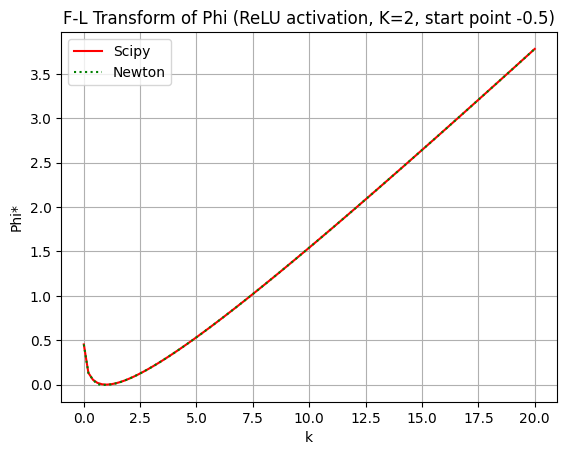

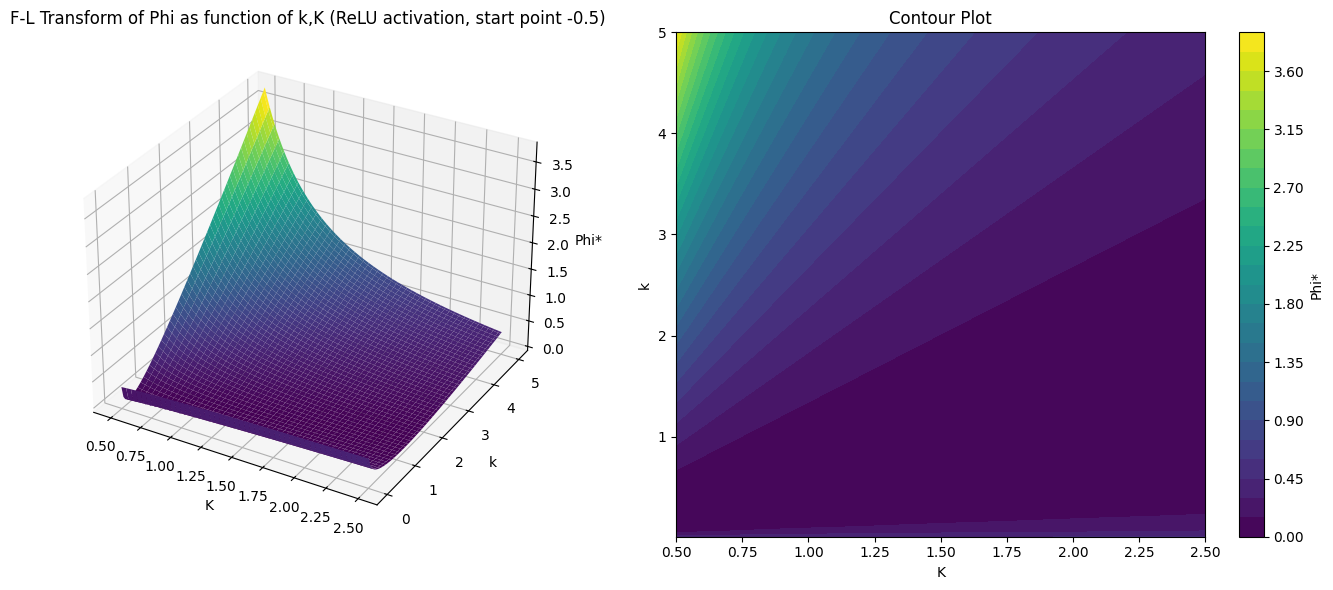

In [7]:
# Plot Fenchel-Legendre transform of Phi computed with different methods
import matplotlib.pyplot as plt
import time as tm

# Range of k_1 values
k_1_values = np.linspace(0.01, 20, 100)
# Range of k_0 values
k_0_values = np.linspace(0.5, 2.5, 100)
learn_rate = 0.01
start_point = -0.5

# Scipy optimization
start = tm.time()
Phi_conj_scipy = [Phi_conjugate_Scipy(k, 2, start_point)[0] for k in k_1_values]
end = tm.time()
print(f"Total runtime of Scipy is {end - start}")
# Gradient Ascent
start = tm.time()
Phi_conj_ga = [Phi_conjugate_GA(k, 2, learn_rate, start_point)[0] for k in k_1_values]
end = tm.time()
print(f"Total runtime of GA is {end - start}")
# Newton's method   
start = tm.time()
Phi_conj_newton = [Phi_conjugate_Newton(k, 2, start_point)[0] for k in k_1_values]
end = tm.time()
print(f"Total runtime of Newton is {end - start}\n")

# Plotting
plt.figure()#figsize = (10, 6))
plt.plot(k_1_values, Phi_conj_scipy, label = 'Scipy', linestyle = '-', color = 'red')
#plt.plot(k_1_values, Phi_conj_ga, label = f'GA (learn rate {learn_rate})', linestyle = ':', color = 'blue')
plt.plot(k_1_values, Phi_conj_newton, label = 'Newton', linestyle = ':',  color = 'green')
plt.title(f'F-L Transform of Phi (ReLU activation, K=2, start point {start_point})')
plt.xlabel('k')
plt.ylabel('Phi*')
plt.legend()
plt.grid()
plt.show()

# Grid points for 3D plot + contour plot
k_1_values = np.linspace(0.01, 5, 100)
K0, K1 = np.meshgrid(k_0_values, k_1_values)
k_values = np.stack([K0.ravel(), K1.ravel()], axis=1)
# Scipy optimization
results = [Phi_conjugate_Scipy(k[1], k[0], start_point)[0] for k in k_values]
results = np.array(results).reshape(K0.shape)
# Plotting
fig = plt.figure(figsize = (14, 6))
# Plot 3D
ax1 = fig.add_subplot(1, 2, 1, projection = '3d')
ax1.plot_surface(K0, K1, results, cmap = 'viridis', edgecolor = 'none')
ax1.set_title(f"F-L Transform of Phi as function of k,K (ReLU activation, start point {start_point})")
ax1.set_xlabel('K')
ax1.set_ylabel('k')
ax1.set_zlabel('Phi*')
# Contour plot
ax2 = fig.add_subplot(1, 2, 2)
contour = ax2.contourf(K0, K1, results, levels = 30, cmap = 'viridis')
fig.colorbar(contour, ax = ax2, label = 'Phi*')
ax2.set_title(f"Contour Plot")
ax2.set_xlabel('K')
ax2.set_ylabel('k')
plt.tight_layout()
plt.show()

In [8]:
# We recursively compute the rate function I(k_output, k_input, layer) for a given layer
# recall that the recursive definition of the rate function is:
# I_K(k_output, k_input, layer) = min_{k_hidden_layer > 0} I(k_hidden_layer, k_input, layer - 1) + Phi_conjugate(k_output, k_hidden_layer)
# while for layer == 1, we have:
# I_K(k_output, k_input, 1) = Phi_conjugate(k_output, k_input)
# We actually define the function so that its output is a double (I_value, k_hidden_layer)
# where I_value is the value of the rate function and k_hidden_layer is the optimal value for the minmization problem

# Scipy optimization
def I_K_Scipy(k_output, k_input, layer, starting_point = 0.3):
    if layer == 1:
        # Base case ---> FL transform and the optimal point is just k_input
        return Phi_conjugate_Scipy(k_output, k_input)[0], k_input
    else:
        # define the target function for the current layer
        def target_function_and_gradient(k_hidden_layer):   
            # Compute the legendre transform for the current layer
            Phi_conj_current, lam_current = Phi_conjugate_Scipy(k_output, k_hidden_layer)
            # Compute the value of the rate function for the past layer and obtain the past optimal k_hidden_layer
            I_prev, k_hidden_layer_prev = I_K_Scipy(k_hidden_layer, k_input, layer - 1, starting_point)
            # Compute the legendre transform for the previous layer (this is needed to compute the gradient)
            _, lam_prev = Phi_conjugate_Scipy(k_hidden_layer, k_hidden_layer_prev)
            # Define the value 
            value = I_prev + Phi_conj_current
            # Define the gradient of the target function 
            gradient = - gradient_Phi_k(lam_current, k_hidden_layer) + lam_prev
            return value, gradient
        # Use scipy's minimize to find the optimal k_hidden_layer
        result = minimize(target_function_and_gradient, x0 = starting_point, method='L-BFGS-B', jac = True, bounds = ((0.001, np.inf),), options = {'disp': False})
        if not result.success:
            raise ValueError("Optimization failed: " + result.message)
        return result.fun, result.x[0]

#Newton's method
def I_K_Newton(k_output, k_input, layer, starting_point = 0.3, num_iterations = 10):
    if layer == 1:
        return Phi_conjugate_Newton(k_output, k_input)[0], k_input
    else:
        k_hidden_layer = starting_point
        for _ in range(num_iterations):
            _, lam_current = Phi_conjugate_Newton(k_output, k_hidden_layer)
            _, k_hidden_layer_prev = I_K_Newton(k_hidden_layer, k_input, layer - 1, starting_point, num_iterations)
            _, lam_prev = Phi_conjugate_Newton(k_hidden_layer, k_hidden_layer_prev)
            grad = - gradient_Phi_k(lam_current, k_hidden_layer) + lam_prev
            hess_lam = hessian_Phi_lam(lam_current, k_hidden_layer)
            mix_hess = mixed_hessian_Phi(lam_current, k_hidden_layer)
            hess_k = hessian_Phi_k(lam_current, k_hidden_layer)
            hess_lam_prev = hessian_Phi_lam(lam_prev, k_hidden_layer_prev)
            hess = (mix_hess**2 / hess_lam) - hess_k + (1 / hess_lam_prev)
            k_updated = k_hidden_layer - (grad / hess)
            if k_updated < 0:
                # min possible step
                k_hidden_layer = 0.001
            else:
                k_hidden_layer = k_updated
    I_k = Phi_conjugate_Newton(k_output, k_hidden_layer)[0] + I_K_Newton(k_hidden_layer, k_input, layer - 1, starting_point, num_iterations)[0]
    return I_k, k_hidden_layer

# Test the functions
import time as tm
k_output = 5
k_input = 2
layer = 4
start_point = 0.3
# Scipy optimization
start = tm.time()
I_K_scipy, k_opt_scipy = I_K_Scipy(k_output, k_input, layer, start_point)
end = tm.time()
print(f"Rate Function I_K for ReLU Activation at Layer {layer + 1}: {I_K_scipy}, minimized at {k_opt_scipy}, total runtime {end - start} (Scipy)")
# Newton's method
start = tm.time()
I_K_newton, k_opt_newton = I_K_Newton(k_output, k_input, layer, start_point)
end = tm.time()
print(f"Rate Function I_K for ReLU Activation at Layer {layer + 1}: {I_K_newton}, minimized at {k_opt_newton}, total runtime {end - start} (Newton)")

Rate Function I_K for ReLU Activation at Layer 5: 0.5070259126365909, minimized at 3.976333709341678, total runtime 3.5904436111450195 (Scipy)
Rate Function I_K for ReLU Activation at Layer 5: 0.5070003142827884, minimized at 3.9260090437816917, total runtime 0.18669486045837402 (Newton)


Total runtime of Scipy is 32.25698494911194
Total runtime of Newton is 1.818222999572754



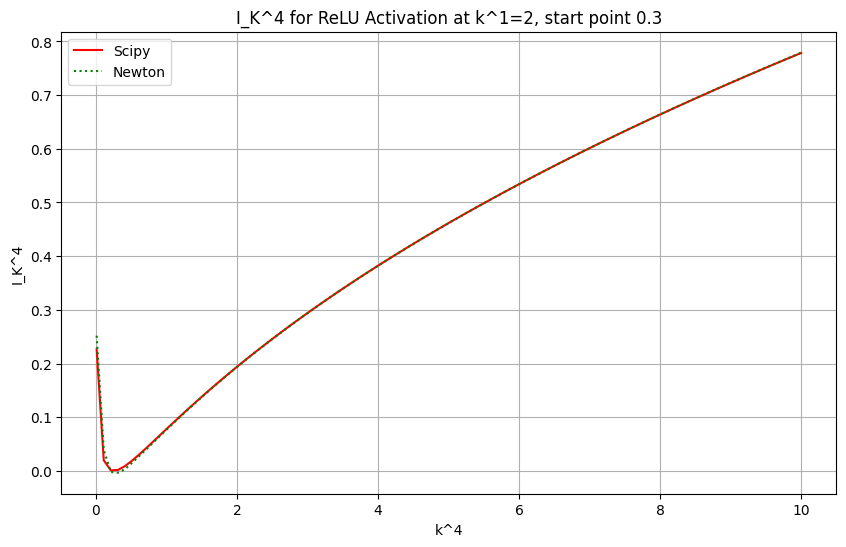

In [10]:
# Plot I_K computed with different methods
import matplotlib.pyplot as plt
import time as tm

# Range of k values
k_values = np.linspace(0.01, 10, 100)
k_input = 2
layer = 3
start_point = 0.3

# Scipy optimization
start = tm.time()
results_scipy = [I_K_Scipy(k_output, k_input, layer)[0] for k_output in k_values]
end = tm.time()
print(f"Total runtime of Scipy is {end - start}")
# Newton's method   
start = tm.time()
results_newton = [I_K_Newton(k_output, k_input, layer, start_point)[0] for k_output in k_values]
end = tm.time()
print(f"Total runtime of Newton is {end - start}\n")

# Plotting
plt.figure(figsize = (10, 6))
plt.plot(k_values, results_scipy, label = 'Scipy', linestyle = '-', color = 'red')
plt.plot(k_values, results_newton, label = 'Newton', linestyle = ':',  color = 'green')
plt.title(f"I_K^{layer+1} for ReLU Activation at k^1={k_input}, start point {start_point}")
plt.xlabel(f'k^{layer+1}')
plt.ylabel(f'I_K^{layer+1}')
plt.grid()
plt.legend()
plt.show()

In [11]:
# Finally we want to calculate the rate funtion I_F for the output of the neural network

from numpy import linalg as la

# Scipy optimization 
def I_F_Scipy(x, k_input, layer, starting_point = 1):
    def target_function_and_gradient_output(k_last_layer):
        # Compute I_K for the last layer and the optimal k (related at the previous layer)
        I_K_value, k_hidden_layer = I_K_Scipy(k_last_layer, k_input, layer)
        # The derivative of I_K is the previous optimal lambda for Phi_conjugate
        _, lam = Phi_conjugate_Scipy(k_last_layer, k_hidden_layer)
        # Define the value and the derivative
        value = I_K_value + la.norm(x)**2 / (2 * k_last_layer)
        gradient = lam - la.norm(x)**2 / (2 * k_last_layer**2)
        return value, gradient
    # Use scipy's minimize to find the optimal k_hidden_layer
    result = minimize(target_function_and_gradient_output, x0 = starting_point, jac = True, method = 'L-BFGS-B', bounds = ((0.001, np.inf),), options = {'disp': False})
    if not result.success:
        raise ValueError("Optimization failed: " + result.message)
    return result.fun, result.x[0]

# Newton's method
def I_F_Newton(x, k_input, layer, starting_point = 1.5, num_iterations = 10):
    k_last_layer = starting_point
    for _ in range(num_iterations):
        _, k_hidden_layer = I_K_Newton(k_last_layer, k_input, layer)
        _, lam = Phi_conjugate_Newton(k_last_layer, k_hidden_layer)
        grad = lam - la.norm(x)**2 / (2 * k_last_layer**2)
        hess = 1 / hessian_Phi_lam(lam, k_hidden_layer) + la.norm(x)**2 / k_last_layer**3
        k_updated = k_last_layer - grad / hess
        if k_updated < 0:
            # min possible step
            k_last_layer = 0.001
        else:
            k_last_layer = k_updated
    I_F = I_K_Newton(k_last_layer, k_input, layer)[0] + la.norm(x)**2 / (2 * k_last_layer)
    return I_F, k_last_layer

# Test the functions
import time as tm
x = 10 #= np.arange(9) - 4
k_input = 2
layer = 3
start_point = 2.5
# Scipy optimization
start = tm.time()
I_F_scipy, k_opt_scipy = I_F_Scipy(x, k_input, layer, start_point)
end = tm.time()
print(f"Rate Function I_F for ReLU activation at Layer {layer + 1}: {I_F_scipy}, minimized at {k_opt_scipy}, total runtime {end - start} (Scipy)")
# Newton's method
start = tm.time()
I_F_newton, k_opt_newton = I_F_Newton(x, k_input, layer, start_point)
end = tm.time()
print(f"Rate Function I_F for ReLU activation at Layer {layer + 1}: {I_F_newton}, minimized at {k_opt_newton}, total runtime {end - start} (Newton)")

Rate Function I_F for ReLU activation at Layer 4: 3.071730564268595, minimized at 46.03598047327341, total runtime 7.8533923625946045 (Scipy)
Rate Function I_F for ReLU activation at Layer 4: 3.168414572585073, minimized at 36.957615715259706, total runtime 0.1867237091064453 (Newton)


Total runtime of Scipy is 258.07460737228394
Total runtime of Newton is 9.977483987808228



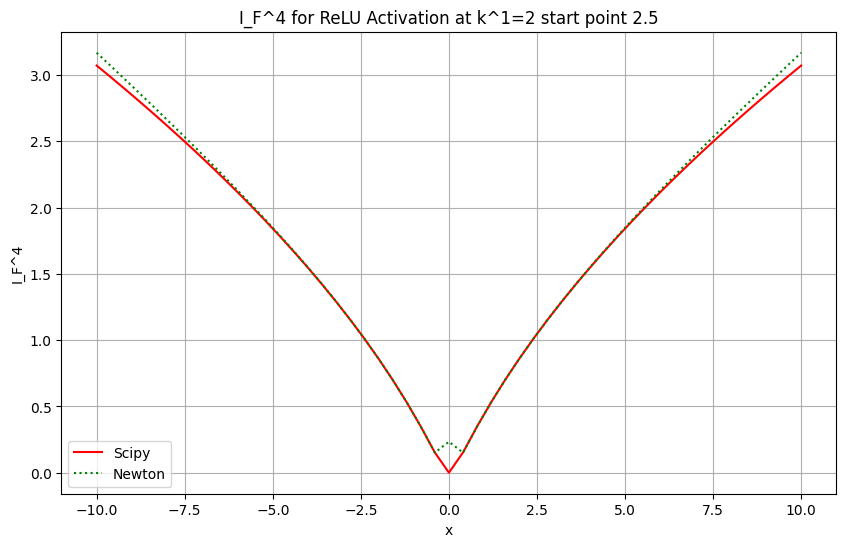

In [14]:
# Plot I_F output dimension = 1
import time as tm

# Range of x values
x_values = np.linspace(-10, 10, 51)
k_input = 2
layer = 3
start_point = 2.5

# Scipy optimization
start = tm.time()
results_scipy = [I_F_Scipy(x, k_input, layer, start_point)[0] for x in x_values]
end = tm.time()
print(f"Total runtime of Scipy is {end - start}")
# Newton's method
start = tm.time()
results_newton = [I_F_Newton(x, k_input, layer, start_point)[0] for x in x_values]
end = tm.time()
print(f"Total runtime of Newton is {end - start}\n")

# Plotting
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 6))
plt.plot(x_values, results_scipy, label = 'Scipy', linestyle = '-', color = 'red')
plt.plot(x_values, results_newton, label = f'Newton', linestyle = ':',  color = 'green')
plt.title(f"I_F^{layer+1} for ReLU Activation at k^1={k_input} start point {start_point}")
plt.xlabel('x')
plt.ylabel(f'I_F^{layer+1}')
plt.grid()
plt.legend()
plt.show()

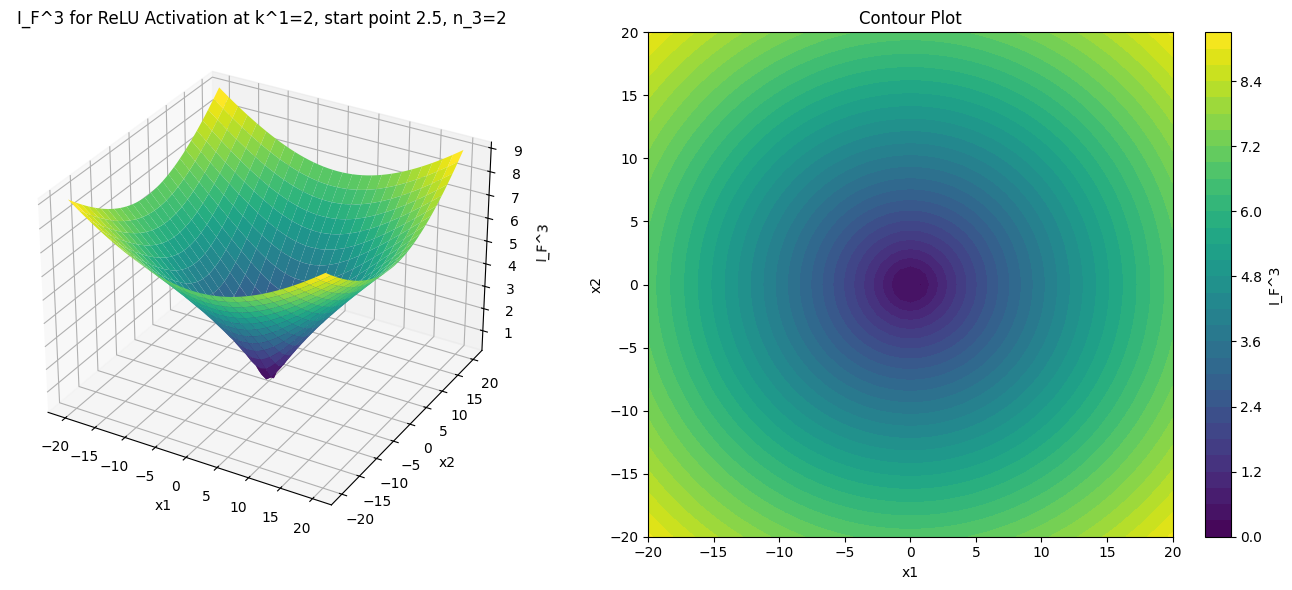

In [20]:
# Plot I_F output dimension = 2
import numpy as np

# Range of x values
x1_range = np.linspace(-20, 20, 51)
x2_range = np.linspace(-20, 20, 51)
# Grid points
X1, X2 = np.meshgrid(x1_range, x2_range)
x_values = np.stack([X1.ravel(), X2.ravel()], axis=1)
layer = 2
k_input = 2
start_point = 2.5

# Scipy optimization
results = [I_F_Newton(x, k_input, layer, start_point)[0] for x in x_values]
results = np.array(results).reshape(X1.shape)

# Plotting
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (14, 6))
# Plot 3D
ax1 = fig.add_subplot(1, 2, 1, projection = '3d')
ax1.plot_surface(X1, X2, results, cmap = 'viridis', edgecolor = 'none')
ax1.set_title(f"I_F^{layer+1} for ReLU Activation at k^1={k_input}, start point {start_point}, n_{layer+1}=2")
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel(f'I_F^{layer+1}')
# Contour plot
ax2 = fig.add_subplot(1, 2, 2)
contour = ax2.contourf(X1, X2, results, levels = 30, cmap = 'viridis')
fig.colorbar(contour, ax = ax2, label = f'I_F^{layer+1}')
ax2.set_title(f"Contour Plot")
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
plt.tight_layout()
plt.show()